# Investigating effective information in artificial neural networks

$$ EI = H(\langle W_i^\text{out} \rangle) - \langle H(W_i^\text{out}) \rangle $$

In [1]:
import os
from pathlib import Path
from itertools import islice
import gzip
import pickle

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

In [2]:
def H(x, dim=0):
    """Compute the Shannon information entropy of x.
    
    Given a tensor x, compute the shannon entropy along one of its axes. If
    x.shape == (N,) then returns a scalar (0-d tensor). If x.shape == (N, N)
    then information can be computed along vertical or horizontal axes by
    passing arguments dim=0 and dim=1, respectively.
    
    Note that the function does not check that the axis along which
    information will be computed represents a valid probability distribution.
    
    Args:
        x (torch.tensor) containing probability distribution
        dim (int) dimension along which to compute entropy
    
    Returns:
        (torch.tensor) of a lower order than input x
    """
    r = x * torch.log2(x)
    r[r != r] = 0
    return -torch.sum(r, dim=dim)


def soft_norm(W):
    """Turns 2x2 matrix W into a transition probability matrix.
    
    The weight/adjacency matrix of an ANN does not on its own allow for EI
    to be computed. This is because the out weights of a given neuron are not
    a probability distribution (they do not necessarily sum to 1). We therefore
    must normalize them. 
    
    Applies a softmax function to each row of matrix
    W to ensure that the out-weights are normalized.
    
    Args:
        W (torch.tensor) of shape (2, 2)
        
    Returns:
        (torch.tensor) of shape (2, 2)
    """
    return F.softmax(W, dim=1)


def lin_norm(W):
    """Turns 2x2 matrix W into a transition probability matrix.
    
    Applies a relu across the rows (to get rid of negative values), and normalize
    the rows based on their arithmetic mean.
    
    Args:
        W (torch.tensor) of shape (2, 2)
        
    Returns:
        (torch.tensor) of shape (2, 2)
    """
    W = F.relu(W)
    row_sums = torch.sum(W, dim=1)
    row_sums[row_sums == 0] = 1
    row_sums = row_sums.reshape((-1, 1))
    return W / row_sums

def sig_norm(W):
    """Turns 2x2 matrix W into a transition probability matrix.
    
    Applies logistic function on each element and normalize
    across rows.
    
    Args:
        W (torch.tensor) of shape (2, 2)
        
    Returns:
        (torch.tensor) of shape (2, 2)
    """
    W = torch.sigmoid(W)
    row_sums = torch.sum(W, dim=1).reshape((-1, 1))
    return W / row_sums


def EI(W, norm=None):
    """Compute effective information from connectivity matrix W."""
    if norm:
        W = norm(W)
    N = int(W.shape[0]) # number of neurons
    degeneracy = H(torch.sum(W, dim=0) / N)
    determinism = torch.mean(H(W, dim=1))   
    return degeneracy - determinism

In [3]:
dir_path = Path().absolute()
dataset_path = dir_path.parent / "data/mnist.pkl.gz"
if not dataset_path.exists():
    print('Downloading dataset with curl ...')
    if not dataset_path.parent.exists():
        os.mkdir(dataset_path.parent)
    url = 'http://ericjmichaud.com/downloads/mnist.pkl.gz'
    os.system('curl -L {} -o {}'.format(url, dataset_path))
print('Download failed') if not dataset_path.exists() else print('Dataset acquired')
f = gzip.open(dataset_path, 'rb')
mnist = pickle.load(f)
f.close()
print('Loaded data to variable `mnist`')

Dataset acquired
Loaded data to variable `mnist`


In [4]:
dtype = torch.cuda.float if torch.cuda.is_available() else torch.float
torch.set_default_dtype(dtype)

In [5]:
class MNISTDataset(Dataset):
    """MNIST Digits Dataset."""
    def __init__(self, data, transform=None):
        self.mnist = data
        self.transform = transform
        
    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        sample = self.mnist[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

class ToTensor(object):
    """Convert samples (np.ndarray, np.ndarray) to (torch.tensor, torch.tensor)"""
    def __call__(self, sample):
        image, one_hot_label = sample
        image = torch.from_numpy(image).to(dtype)
        label = torch.tensor(np.argmax(one_hot_label)).to(torch.long)
        return (image, label)


In [6]:
training = MNISTDataset(mnist[:60000], transform=ToTensor())
test = MNISTDataset(mnist[60000:], transform=ToTensor())
training_loader = torch.utils.data.DataLoader(training, batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=100, shuffle=True)

In [14]:
class SoftmaxRegression(nn.Module):
    """Single-layer softmax network."""
    def __init__(self, n_in, n_out):
        super(SoftmaxRegression, self).__init__()
        self.linear = nn.Linear(n_in, n_out, bias=False)
    
    def forward(self, x):
        return F.log_softmax(self.linear(x), dim=1)
        
model = SoftmaxRegression(28*28, 10)
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters())

In [15]:
W = torch.zeros((28*28 + 10, 28*28 + 10))

In [16]:
results = []
num_batches = 0
for epoch in range(2):
    for sample, target in training_loader:
        optimizer.zero_grad()
        loss_fn(model(sample), target).backward()
        optimizer.step()
        num_batches += 1
        if num_batches % 100 == 0:
            correct = 0
            outof = 0
            with torch.no_grad():
                for x, labels in islice(test_loader, 0, 10): # 10 batches of 100 samples
                    output = model(x)
                    _, pred = torch.max(output, 1)
                    correct += (pred == labels).sum().item()
                    outof += len(labels)
            W[:28*28, 28*28:] = model.linear.weight.t()
            results.append((num_batches, correct / outof, EI(W, norm=lin_norm)))
            # print("Epoch {} | Accuracy = {:.4f}%".format(epoch, correct / len(test)))
            # print("Epoch {} |    EI    = {:.6f}".format(epoch, EI(W, norm=lin_norm)))
            # print("done with {} batches".format(num_batches))

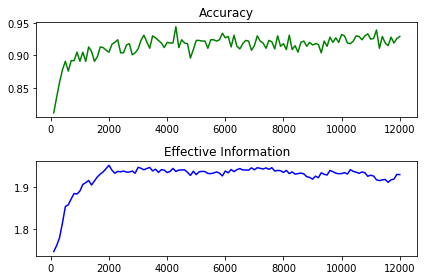

In [17]:
x, ac, ei = zip(*results)

plt.subplot(2, 1, 1)
plt.plot(x, ac, label='Accuracy', color='green')
plt.title("Accuracy")
plt.subplot(2, 1, 2)
plt.plot(x, ei, label='EI', color='blue')
plt.title("Effective Information")
# fig, ax1 = plt.subplots()

# ax1.set_xlabel('num_batches')
# ax1.plot(x, ac, label='accuracy', color='blue')
# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# ax2.plot(x, ei, label='ei', color='red')

plt.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
with torch.no_grad():
    for i in range(10):
        weights = model.linear.weight[i].reshape(28,28)
        plt.subplot(2, 5, i+1)
        plt.imshow(weights.detach().numpy(), cmap='plasma')
        plt.title(str(i))

In [ ]:
torch.zeros(5)

In [ ]:
N = 100
EI(torch.normal(mean=torch.zeros((N, N)), std=1), norm=lin_norm)

In [ ]:
N = 100
EI(torch.rand((N,N)))

In [ ]:
N = 100
m = torch.zeros((N, N))
for i in range(N):
    m[i][(i-1)%N] = 1
    m[i][(i+1)%N] = 1

In [ ]:
EI(m, norm=lin_norm).item()